<head>
    <title> AI for the industry </title>
    </head>


DESCRIPTION: A company producing fiber optic sensors decided to implement the concept
of Industry 4.0 in one of their production processes. They are going to
implement the AI techniques to automate verification of produced sensors.
Currently, after the production of the sensor, its characteristics should be
verified each time in three reference substances in order to configure:
<ui>
    <li> Air </li>
    <li> Water </li>
    <li> Isopropanol </li>
    </ui>
After the procedure in the laboratory they collected three spectroscopic
signals. Unfortunately, such procedures are extremely time consuming and
require large human resources. Therefore they are planning to implement AI
algorithms in order to predict characteristics (or any other parameters – you
can propose something) of a working sensor in water and isopropanol based
on measured characteristics in air. It will enable to reduce validation process
only to measurements in the air, but other characteristics will be collected
based on the proposed model.


<h1> Model proposition and expectation </h1>

The goal is to find model that allows to predict sensor spectral characteristic in the water and in the izopropanol based on readouts performed in the air. 
In other words, the models (separately for water and izopropanol) will be built on the data: waveleghts and amplitude read in the air. Amplitude in the water or in the izopropanol will be predicted.

<ol>
<li>Preposition of model: regression based</li>
<li>Model has to be accurate</li>
<li>Metrics: R2 - should be close 1, MAE, MSE, RMSE - should be as low as possible, close to 0 </li>
</ol>

<h1>1. Import of needed packages and checking of python and pandas version<h1>

In [ ]:
pip install -U scikit-learn

<h1> 1. Import packages </h1>

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error 

In [3]:
from platform import python_version
print(python_version())

3.9.16


In [4]:
print(pd.__version__)

1.5.3


<h1>2. import of data and dataframes generation<h1>



Data are saved as .txt files however the data format looks like .csv format - two series of numebrs are separated with ",".

All Data from link to GoogleDrive were downloaded to local drive for this project. However, I can imagine that in the future the number of collected data will be higher and some ETL tools should be used then to collect the data, process them, analyse and use. For now, I propose Python-based tools (OS and Pandas packages).

In [5]:
# link to folder with data on my local drive
data_folder = '/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/**/*'

# list of content data_folder
for filename in glob.iglob(data_folder,
                           recursive = True):
    print(filename)

/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/sesion_07_20
/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/sesion_03_20
/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/sesion_02_20
/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/sesion_06_20
/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/sesion_09_20
/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/sesion_08_20
/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/sesion_01_20
/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/sesion_05_20
/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/sesion_04_20
/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/sesion_10_20
/Users/izabela_kania_ds/DataScience/DS_Projects/Co

As we can see, the data is structured in 10 folders named as "session_noXX_20" and each contains 3 .txt files wchich are spectral readouts of the corresponding sensor in the air, water and izopropanol. 

Let's create lists of data sets readouts in each environment separative.

In [ ]:
# creating of lists with data sets collecting readouts in air, water and isopropanol

air_data = glob.glob(data_folder + '*air.*')
air_data

In [ ]:
water_data = glob.glob(data_folder + '*water.*')
water_data

In [ ]:
izopropanol_data = glob.glob(data_folder + '*izopropanol.*')
izopropanol_data

Looking into one sample dataset

In [337]:
air06 = pd.read_csv('/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/sesion_06_20/sensor06_air.txt', header=None, index_col=False)
water06 = pd.read_csv('/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/sesion_06_20/sensor06_water.txt', header=None, index_col=False)
izopropanol06 = pd.read_csv('/Users/izabela_kania_ds/DataScience/DS_Projects/Codecool_recruitment_task/Dataset/sesion_06_20/sensor06_izopropanol.txt', header=None, index_col=False)
print('sensor 06 in the air:', air06.head())
print('sensor 06 in the water:', water06.head())
print('sensor 06 in isopropanol:', izopropanol06.head())

sensor 06 in the air:           0       1
0  0.000001  9.4554
1  0.000001  9.6052
2  0.000001  9.6264
3  0.000001  9.5136
4  0.000001  9.4042
sensor 06 in the water:           0       1
0  0.000001  8.7331
1  0.000001  8.7934
2  0.000001  8.7887
3  0.000001  8.7277
4  0.000001  8.7171
sensor 06 in isopropanol:           0       1
0  0.000001  8.8085
1  0.000001  9.0038
2  0.000001  8.9254
3  0.000001  8.8786
4  0.000001  8.8290


Observations:
<ul>
    <li>Data are complete, there are no NaN</li>
    <li>Dataframe does not contain header </li>
    <li>First column is a wavelenght expressed in meters. Usually, wavelenght is expressed in nanometers, which is 1/1000000000 of meter</li>
    <li>In the second column we have Signal Amplitude </li>

</ul>

<h2>2.1 Generation of dataframe for each environment</h2>

In [11]:
# Dataframe modification to be more readable



def mod_df(df):
    df.columns = ['Wavelenght [nm]', 'Amplitude']
    df['Wavelenght [nm]'] = df['Wavelenght [nm]'] * 1000000000
    return


In [12]:
# checking whether the function mod_df(df) works

mod_df(izopropanol06)
izopropanol06

Wavelenght [nm]  Amplitude
0              1350.0     8.8085
1              1350.1     9.0038
2              1350.2     8.9254
3              1350.3     8.8786
4              1350.4     8.8290
...               ...        ...
2996           1649.6    -1.5332
2997           1649.7    -1.3984
2998           1649.8    -1.4084
2999           1649.9    -1.1342
3000           1650.0    -1.0098

[3001 rows x 2 columns]

In [319]:
# checking whether the function mod_df(df) works

mod_df(water06)
water06

Wavelenght [nm]  Amplitude
0        1.350000e+12     8.7331
1        1.350100e+12     8.7934
2        1.350200e+12     8.7887
3        1.350300e+12     8.7277
4        1.350400e+12     8.7171
...               ...        ...
2996     1.649600e+12    -1.8323
2997     1.649700e+12    -1.7141
2998     1.649800e+12    -1.9062
2999     1.649900e+12    -1.7105
3000     1.650000e+12    -1.5242

[3001 rows x 2 columns]

In [338]:
# checking whether the function mod_df(df) works
mod_df(air06)
air06

Wavelenght [nm]  Amplitude
0              1350.0     9.4554
1              1350.1     9.6052
2              1350.2     9.6264
3              1350.3     9.5136
4              1350.4     9.4042
...               ...        ...
2996           1649.6     2.4787
2997           1649.7     2.9384
2998           1649.8     2.4859
2999           1649.9     2.9317
3000           1650.0     2.8220

[3001 rows x 2 columns]

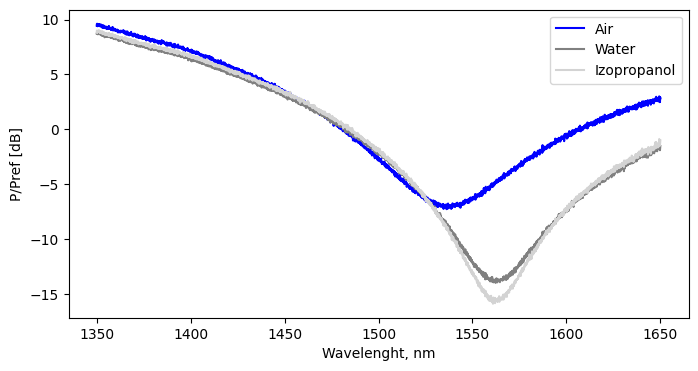

In [14]:
# ploting of data from Sensor06 readouts

fig, ax = plt.subplots(figsize=(8, 4))

ax.set_xlabel("Wavelenght, nm")
ax.set_ylabel("P/Pref [dB]")

ax.plot(air06['Wavelenght [nm]'], air06['Amplitude'], color = 'blue', label = 'Air')
ax.plot(water06['Wavelenght [nm]'], water06['Amplitude'], color = 'grey', label = 'Water')
ax.plot(izopropanol06['Wavelenght [nm]'], izopropanol06['Amplitude'], color = 'lightgrey', label = 'Izopropanol')

ax.legend()

plt.show()


For modeling, I will use data from 8 sensors (numbered as sensor1-sensor8); 2 of them I will use for deployment.

Sensor ID will be added to dataframes as a new column, however it would be not used as parameter for modelling.

In [15]:
# creating of datasets 

air_files = sorted(glob.glob(data_folder + '*0[0-8]_air.txt'))


files = []

for filename in air_files:
    df = pd.read_csv(filename, header=None, index_col=None)
    mod_df(df)
    df['SensorID']=filename[-16:-8] # extraction of sensor id should be done another way
    df = df[['SensorID'] + list(df.columns[:-1])]
    files.append(df)

air_df = pd.concat(files, axis=0, ignore_index=True)

air_df

SensorID  Wavelenght [nm]  Amplitude
0      sensor01           1350.0     9.1792
1      sensor01           1350.1     9.2003
2      sensor01           1350.2     9.1968
3      sensor01           1350.3     9.1028
4      sensor01           1350.4     9.0601
...         ...              ...        ...
24003  sensor08           1649.6     3.7791
24004  sensor08           1649.7     3.6568
24005  sensor08           1649.8     3.7064
24006  sensor08           1649.9     3.7920
24007  sensor08           1650.0     4.0038

[24008 rows x 3 columns]

In [16]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24008 entries, 0 to 24007
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SensorID         24008 non-null  object 
 1   Wavelenght [nm]  24008 non-null  float64
 2   Amplitude        24008 non-null  float64
dtypes: float64(2), object(1)
memory usage: 562.8+ KB


In [17]:
water_files = sorted(glob.glob(data_folder + '*0[0-8]_water.txt'))


files = []

for filename in water_files:
    df = pd.read_csv(filename, header=None, index_col=None)
    mod_df(df)
    df['SensorID']=filename[-18:-10]
    df = df[['SensorID'] + list(df.columns[:-1])]
    files.append(df)

water_df = pd.concat(files, axis=0, ignore_index=True)

water_df

SensorID  Wavelenght [nm]  Amplitude
0      sensor01           1350.0    8.35700
1      sensor01           1350.1    8.42870
2      sensor01           1350.2    8.44220
3      sensor01           1350.3    8.41440
4      sensor01           1350.4    8.40340
...         ...              ...        ...
24003  sensor08           1649.6   -0.47930
24004  sensor08           1649.7   -0.51990
24005  sensor08           1649.8   -0.77034
24006  sensor08           1649.9   -0.40282
24007  sensor08           1650.0   -0.28101

[24008 rows x 3 columns]

In [18]:
water_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24008 entries, 0 to 24007
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SensorID         24008 non-null  object 
 1   Wavelenght [nm]  24008 non-null  float64
 2   Amplitude        24008 non-null  float64
dtypes: float64(2), object(1)
memory usage: 562.8+ KB


In [19]:
izopropanol_files = sorted(glob.glob(data_folder + '*0[0-8]_izopropanol.txt'))


files = []

for filename in izopropanol_files:
    df = pd.read_csv(filename, header=None, index_col=None)
    mod_df(df)
    df['SensorID']=filename[-24:-16]
    df = df[['SensorID'] + list(df.columns[:-1])]
    files.append(df)

izopropanol_df = pd.concat(files, axis=0, ignore_index=True)

izopropanol_df

SensorID  Wavelenght [nm]  Amplitude
0      sensor01           1350.0   8.555100
1      sensor01           1350.1   8.675000
2      sensor01           1350.2   8.711600
3      sensor01           1350.3   8.715700
4      sensor01           1350.4   8.679200
...         ...              ...        ...
24003  sensor08           1649.6  -0.179920
24004  sensor08           1649.7  -0.329130
24005  sensor08           1649.8  -0.503520
24006  sensor08           1649.9  -0.042660
24007  sensor08           1650.0   0.063801

[24008 rows x 3 columns]

In [20]:
izopropanol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24008 entries, 0 to 24007
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SensorID         24008 non-null  object 
 1   Wavelenght [nm]  24008 non-null  float64
 2   Amplitude        24008 non-null  float64
dtypes: float64(2), object(1)
memory usage: 562.8+ KB


NOTE: A function for generatig of the dataframes is needed. I tried to do that and the only problem I need to solve is extraction of Sensor ID in 'Sensor_ID' column from the file path.

'''

def generate_dataframes(df_name):

    file_path = file_path # file path would be: sorted(glob.glob(data_folder + '*0[0-8]_izopropanol.txt')) for izopropanol ect.

    files = []

    for filename in file_path:
        df = pd.read_csv(filename, header=None, index_col=None)
        mod_df(df)
        df['SensorID']=filename[-24:-16] #these idea must be changed; filename[-24:-16] is only for izopropanol data; automation needed
        df = df[['SensorID'] + list(df.columns[:-1])]
        files.append(df)

    df_name = pd.concat(files, axis=0, ignore_index=True)
    return df_name

'''

<h3>Plotting of data <h3>

In [21]:
def spectrum_plot(data):

    fig, ax = plt.subplots(figsize=(10,6))
    sensors = list(data.SensorID.unique())
    for s in sensors:
        df = data.loc[data['SensorID'] == s]
        ax.plot(df['Wavelenght [nm]'], df['Amplitude'])
    ax.set_xlabel("Wavelenght, nm")
    ax.set_ylabel("P/Pref [dB]")
    return

plt.show()

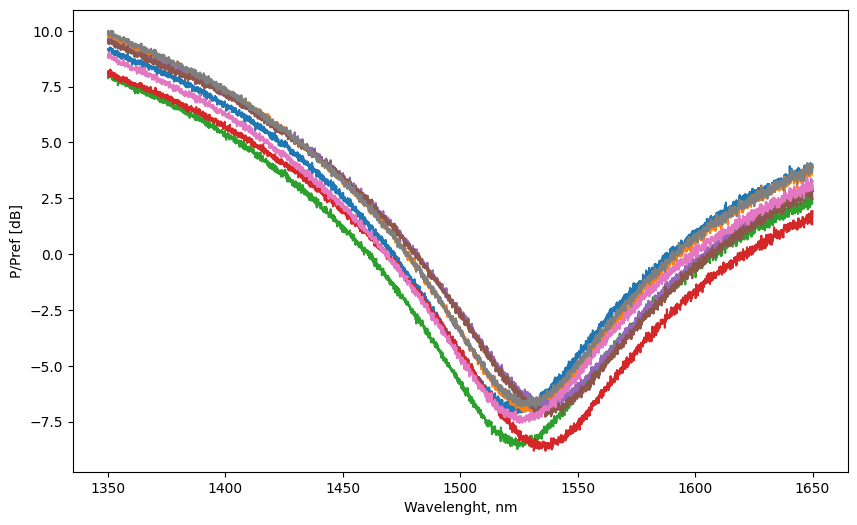

In [22]:
spectrum_plot(air_df)

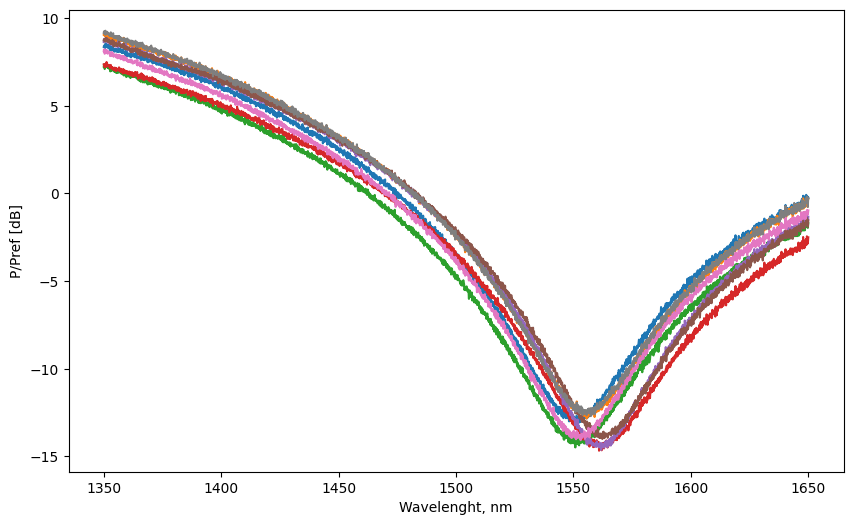

In [23]:
spectrum_plot(water_df)

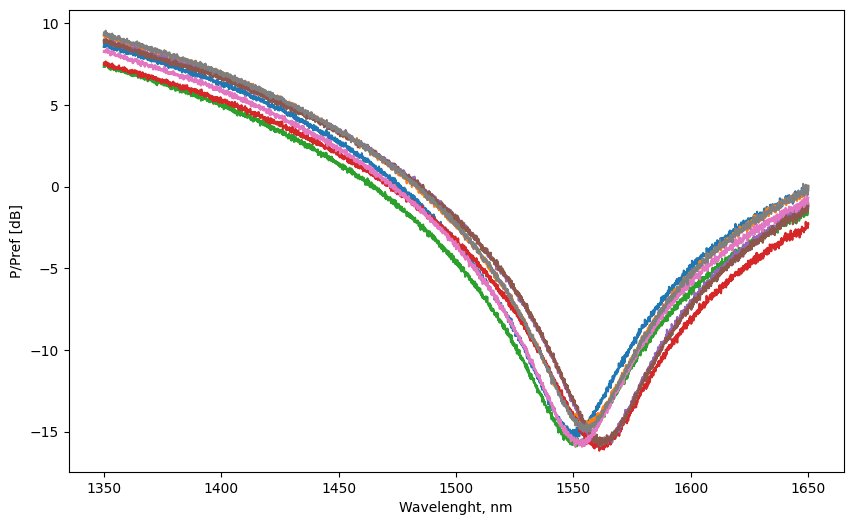

In [24]:
spectrum_plot(izopropanol_df)

<h1>3. Models</h1>

<h2>3.1. Merging data into big dataframe</h2>

In [25]:
# Rename of columns -> clarifying of data after merging

air_df = air_df.rename(columns={'Amplitude' : 'Amplitude in air'})
water_df = water_df.rename(columns={'Amplitude' : 'Amplitude in water'})
izopropanol_df = izopropanol_df.rename(columns={'Amplitude' : 'Amplitude in izopropanol'})


# Dataframe for readouts in the air and in water
data01 = air_df.merge(water_df, on=('SensorID','Wavelenght [nm]'))
data01

SensorID  Wavelenght [nm]  Amplitude in air  Amplitude in water
0      sensor01           1350.0            9.1792             8.35700
1      sensor01           1350.1            9.2003             8.42870
2      sensor01           1350.2            9.1968             8.44220
3      sensor01           1350.3            9.1028             8.41440
4      sensor01           1350.4            9.0601             8.40340
...         ...              ...               ...                 ...
24003  sensor08           1649.6            3.7791            -0.47930
24004  sensor08           1649.7            3.6568            -0.51990
24005  sensor08           1649.8            3.7064            -0.77034
24006  sensor08           1649.9            3.7920            -0.40282
24007  sensor08           1650.0            4.0038            -0.28101

[24008 rows x 4 columns]

In [26]:
# Dataframe for readouts in the air and izopropanol

data02 = air_df.merge(izopropanol_df, on=('SensorID', 'Wavelenght [nm]'))
data02

SensorID  Wavelenght [nm]  Amplitude in air  Amplitude in izopropanol
0      sensor01           1350.0            9.1792                  8.555100
1      sensor01           1350.1            9.2003                  8.675000
2      sensor01           1350.2            9.1968                  8.711600
3      sensor01           1350.3            9.1028                  8.715700
4      sensor01           1350.4            9.0601                  8.679200
...         ...              ...               ...                       ...
24003  sensor08           1649.6            3.7791                 -0.179920
24004  sensor08           1649.7            3.6568                 -0.329130
24005  sensor08           1649.8            3.7064                 -0.503520
24006  sensor08           1649.9            3.7920                 -0.042660
24007  sensor08           1650.0            4.0038                  0.063801

[24008 rows x 4 columns]

In [27]:
data_all = data01.merge(izopropanol_df, on=('SensorID', 'Wavelenght [nm]'))
data_all

SensorID  Wavelenght [nm]  Amplitude in air  Amplitude in water  \
0      sensor01           1350.0            9.1792             8.35700   
1      sensor01           1350.1            9.2003             8.42870   
2      sensor01           1350.2            9.1968             8.44220   
3      sensor01           1350.3            9.1028             8.41440   
4      sensor01           1350.4            9.0601             8.40340   
...         ...              ...               ...                 ...   
24003  sensor08           1649.6            3.7791            -0.47930   
24004  sensor08           1649.7            3.6568            -0.51990   
24005  sensor08           1649.8            3.7064            -0.77034   
24006  sensor08           1649.9            3.7920            -0.40282   
24007  sensor08           1650.0            4.0038            -0.28101   

       Amplitude in izopropanol  
0                      8.555100  
1                      8.675000  
2                      8.711600  
3                      8.715700  
4                      8.679200  
...                         ...  
24003                 -0.179920  
24004                 -0.329130  
24005                 -0.503520  
24006                 -0.042660  
24007                  0.063801  

[24008 rows x 5 columns]

Data in column 'Wavelenght [nm]' will be converted to reach 1.XX values

In [28]:
data_all['Wavelenght_units'] = data_all['Wavelenght [nm]'] / 1000
data_all

SensorID  Wavelenght [nm]  Amplitude in air  Amplitude in water  \
0      sensor01           1350.0            9.1792             8.35700   
1      sensor01           1350.1            9.2003             8.42870   
2      sensor01           1350.2            9.1968             8.44220   
3      sensor01           1350.3            9.1028             8.41440   
4      sensor01           1350.4            9.0601             8.40340   
...         ...              ...               ...                 ...   
24003  sensor08           1649.6            3.7791            -0.47930   
24004  sensor08           1649.7            3.6568            -0.51990   
24005  sensor08           1649.8            3.7064            -0.77034   
24006  sensor08           1649.9            3.7920            -0.40282   
24007  sensor08           1650.0            4.0038            -0.28101   

       Amplitude in izopropanol  Wavelenght_units  
0                      8.555100            1.3500  
1                      8.675000            1.3501  
2                      8.711600            1.3502  
3                      8.715700            1.3503  
4                      8.679200            1.3504  
...                         ...               ...  
24003                 -0.179920            1.6496  
24004                 -0.329130            1.6497  
24005                 -0.503520            1.6498  
24006                 -0.042660            1.6499  
24007                  0.063801            1.6500  

[24008 rows x 6 columns]

<h2>3.2. Splitting data into train and test set </h2>

In [53]:
# determination of dependent and independent variables


X = data_all[['Wavelenght_units', 'Amplitude in air']] # independent variable will be the same for water and izopropanol models
y_water = data_all['Amplitude in water']
y_izo = data_all['Amplitude in izopropanol']



0        8.35700
1        8.42870
2        8.44220
3        8.41440
4        8.40340
          ...   
24003   -0.47930
24004   -0.51990
24005   -0.77034
24006   -0.40282
24007   -0.28101
Name: Amplitude in water, Length: 24008, dtype: float64

In [30]:
# Split for model in water
X_water_train, X_water_test, y_water_train, y_water_test = train_test_split(X,y_water,test_size=0.2,random_state=40)

#Split for model in izopropanol
X_izo_train, X_izo_test, y_izo_train, y_izo_test = train_test_split(X,y_izopropanol,test_size=0.2,random_state=111)

<h2>3.3. MODEL: polynominal regression</h2>

In [278]:
# Collecting of models metrics

metrics = pd.DataFrame(columns=['Model', 'Dataset', 'R2','MAE', 'MSE', 'RMSE'])
metrics

Empty DataFrame
Columns: [Model, Dataset, R2, MAE, MSE, RMSE]
Index: []

<h3>3.3a. Water polynominal regression </h3>

plotted data showed, that the regression is nonlinear.



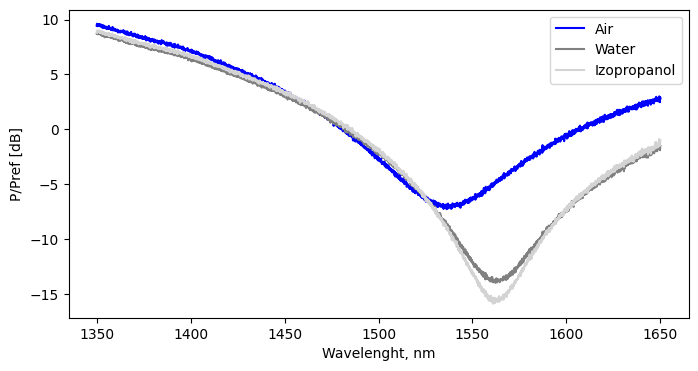

<h4>3.3a (WATER).1) polynominal regression model with degree=3 </h4>


In [312]:
def poly(X, y, poly_degree, model):
    
    '''
    
    Function that fits polynominal regression model of X and y data with polynomial degree = poly_degree and predicts data.
    
    Function returnes charactericstic of polynomial regression (intercept and coefficients) and scores of the model (R2, MAE MSE, RMSE)
    
    '''

    # transformation X
    poly = PolynomialFeatures(degree=poly_degree) 
    X_poly = poly.fit_transform(X)

    # model fitting
    model = LinearRegression()
    model.fit(X_poly, y)

    print(f'Polynominal regression model with degree {poly_degree} function is characterized with COEFFICIENTS: {model.coef_}')

    #prediction of training sets
    y_poly_pred = model.predict(X_poly)
    
    #scaterplot of true and predicted values
    plt.scatter(y, y_poly_pred)
    
    # parameters
    mae_reg = mean_absolute_error(y, y_poly_pred)
    mse_reg = mean_squared_error(y, y_poly_pred)
    rmse_reg = np.sqrt(mean_squared_error(y, y_poly_pred))
    r2_reg = r2_score(y, y_poly_pred)

    print(f'Parameters of polynominal regression model for degree {poly_degree}:')
    print(f'MAE: {mae_reg}, MSE: {mse_reg}, RMSE: {rmse_reg}, R2: {r2_reg}')
    
    return mae_reg, mse_reg, rmse_reg, r2_reg


Polynominal regression model with degree 3 function is characterized with COEFFICIENTS: [ 0.00000000e+00  1.39291008e+04 -2.34097361e+01 -9.32221341e+03
  2.11286885e+01  2.73834026e+00  2.06950416e+03 -3.36017940e+00
 -1.81563679e+00 -1.04281163e-02]
Parameters of polynominal regression model for degree 3:
MAE: 0.495498157545461, MSE: 0.48562805622760535, RMSE: 0.6968701860659597, R2: 0.9889393250199096


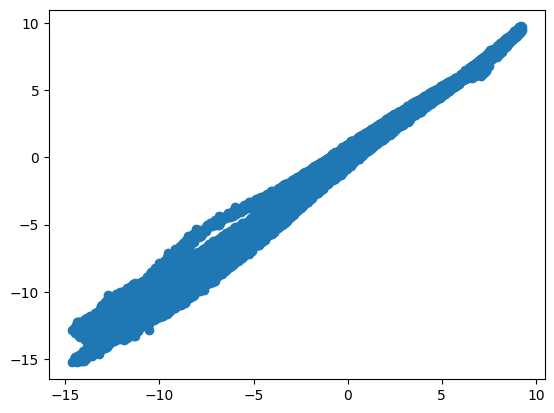

In [313]:
# Polynominal degree 3

water_poly3= poly(X_water_train, y_water_train, 3, 'model01_poly')




In [311]:
import pickle

def save_poly(X, y, poly_degree, filename):
    
    '''
    
    Function that fits polynominal regression model of X and y data with polynomial degree = poly_degree and predicts data.
    
    Function returnes charactericstic of polynomial regression (intercept and coefficients) and scores of the model (R2, MAE MSE, RMSE)
    
    Saves the model to a file.
    
    '''
    
    # transformation X
    poly = PolynomialFeatures(degree=poly_degree) 
    X_poly = poly.fit_transform(X)

    # model fitting
    model = LinearRegression()
    model.fit(X_poly, y)

    print(f'Polynominal regression model with degree {poly_degree} function is characterized with COEFFICIENTS: {model.coef_}')
    filename = filename + '.pkl'
    # serialize (save) the object, in this case "model"
    pickle.dump(model, open(filename, 'wb'))
    
    return

In [306]:
water_poly3 = save_poly(X_water_train, y_water_train, 3, 'water_poly3')

Polynominal regression model with degree 3 function is characterized with: 
 INTERCEPT: -6904.775957993821 
 COEFFICIENTS: [ 0.00000000e+00  1.39291008e+04 -2.34097361e+01 -9.32221341e+03
  2.11286885e+01  2.73834026e+00  2.06950416e+03 -3.36017940e+00
 -1.81563679e+00 -1.04281163e-02]


In [310]:
# de-serialize (load) the object
imported_model = pickle.load(open('water_poly3.pkl', 'rb'))

poly = PolynomialFeatures(degree=3) 
X_test_poly = poly.fit_transform(X_water_test)

# use the imported model (example)
y_test_poly_pred = imported_model.predict(X_test_poly)

# parameters
mae_reg_test = mean_absolute_error(y_water_test, y_test_poly_pred)
mse_reg_test = mean_squared_error(y_water_test, y_test_poly_pred)
rmse_reg_test = np.sqrt(mean_squared_error(y_water_test, y_test_poly_pred))
r2_reg_test = r2_score(y_water_test, y_test_poly_pred)

print('Parameters of polynominal regression model for test water dataset for degree 3:')
print(f'MAE: {mae_reg_test}, MSE: {mse_reg_test}, RMSE: {rmse_reg_test}, R2: {r2_reg_test}')

Parameters of polynominal regression model for test water dataset for degree 3:
MAE: 0.49340485917854077, MSE: 0.4904440292264155, RMSE: 0.700317091913667, R2: 0.9885995403595245


In [148]:
# prediction of test dataset and metrics evaluation

def poly_reg_predict(X, y, poly_degree, model):

'''

function to predict test data set) using defined model

function returns metrics for test set


'''

# X transfromation
    poly = PolynomialFeatures(degree=poly_degree) 
    X_poly = poly.fit_transform(X)

    #predictions
    y_poly_pred = model.predict(X)

# parameters
mae_reg= mean_absolute_error(y_water_test, y_test_poly_pred)
mse_reg_test = mean_squared_error(y_water_test, y_test_poly_pred)
rmse_reg_test = np.sqrt(mean_squared_error(y_water_test, y_test_poly_pred))
r2_reg_test = r2_score(y_water_test, y_test_poly_pred)

print('Parameters of polynominal regression model for test water dataset for degree 3:')
print(f'MAE: {mae_reg_test}, MSE: {mse_reg_test}, RMSE: {rmse_reg_test}, R2: {r2_reg_test}')


X_poly_test = poly.fit_transform(X_water_test)

#prediction of training sets
y_test_poly_pred = model01.predict(X_poly_test)

# parameters
mae_reg_test= mean_absolute_error(y_water_test, y_test_poly_pred)
mse_reg_test = mean_squared_error(y_water_test, y_test_poly_pred)
rmse_reg_test = np.sqrt(mean_squared_error(y_water_test, y_test_poly_pred))
r2_reg_test = r2_score(y_water_test, y_test_poly_pred)

print('Parameters of polynominal regression model for test water dataset for degree 3:')
print(f'MAE: {mae_reg_test}, MSE: {mse_reg_test}, RMSE: {rmse_reg_test}, R2: {r2_reg_test}')

Parameters of polynominal regression model for water for degree 3:
MAE: 0.49340485917854077, MSE: 0.4904440292264155, RMSE: 0.700317091913667, R2: 0.9885995403595245


<h4>3.3a (WATER).2) Polynominal regression model with degree tuning </h4>

In [159]:
 #Function to fit different models
from sklearn.pipeline import Pipeline

def fit_polynomials(X, y, from_=1, to_= 10, step=1):
  '''
  This function takes the explanatory (X) and response variables (y) and runs the data through a pipeline that fits Linear Regressions
  of different degrees (values specified by the user) and plot the results.
  Inputs:
  * from: int = initial degree for polynomial fit
  * to: int = final degree for polynomial fit
  * step:int = step to increase
  * X = explanatory variables
  * y = target variable

  Returns:
  score
  '''

  # Store scores and predictions
  scores = []

  # Loop between the specified values
  for n in range(from_, to_+1, step):
    # Steps
    steps = [
        ('Polynomial', PolynomialFeatures(degree=n)),
        ('model', LinearRegression())  ]
    
    # Pipeline fit
    fit_poly = Pipeline(steps).fit(X,y)
    # Predict
    poly_pred = fit_poly.predict(X)
    
    # y : y_predict scatter plot
    fig, ax = plt.subplots(figsize = (4, 4))
    ax.set_title("Prediction scatterplot for polynomial degree = " + str(n))
    ax.scatter(y, poly_pred)
    plt.show()
    
    # Evaluate
    model_score = fit_poly.score(X,y)
    model_mae = mean_absolute_error(y, poly_pred)
    model_mse = mean_squared_error(y, poly_pred)
    scores.append((n, model_score, model_mae, model_mse))

  return scores

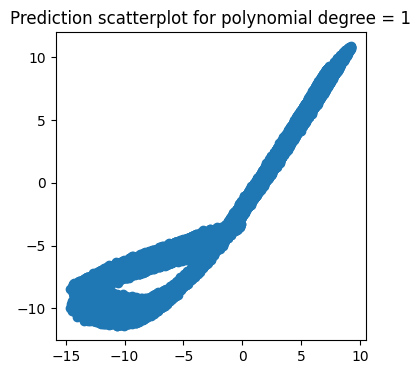

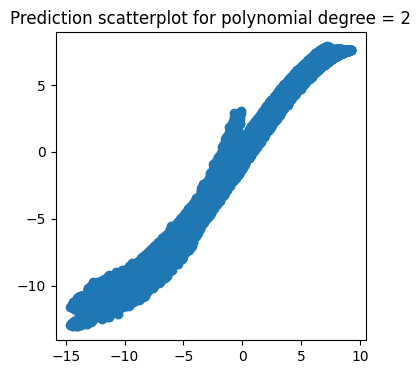

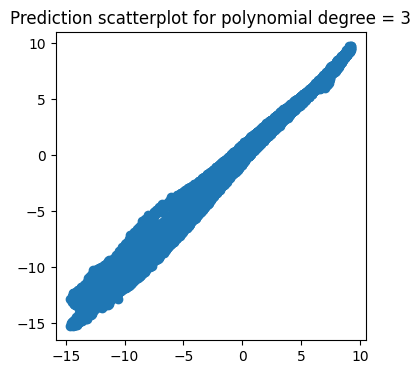

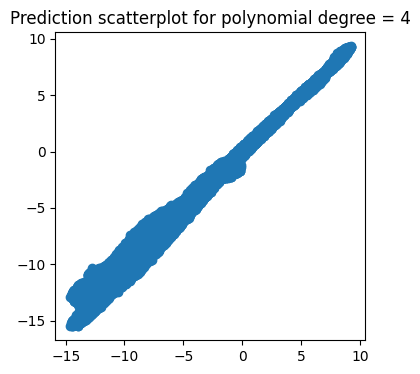

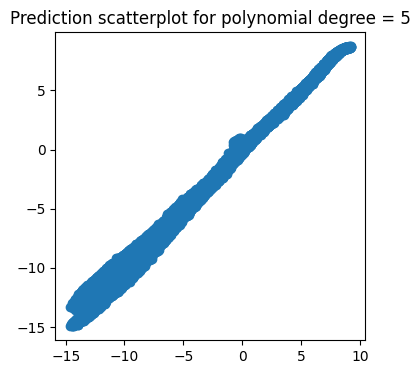

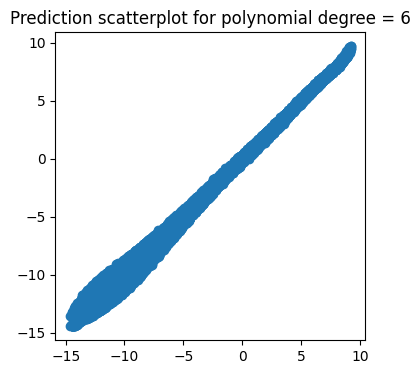

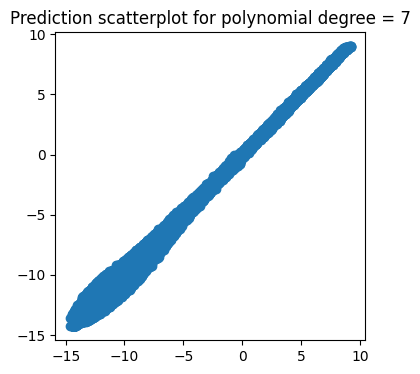

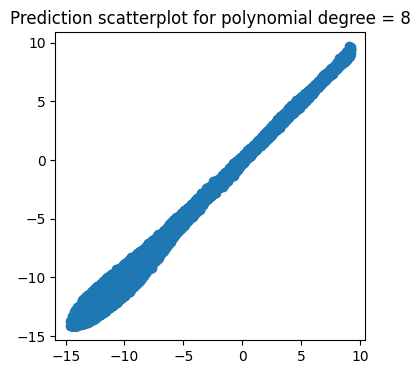

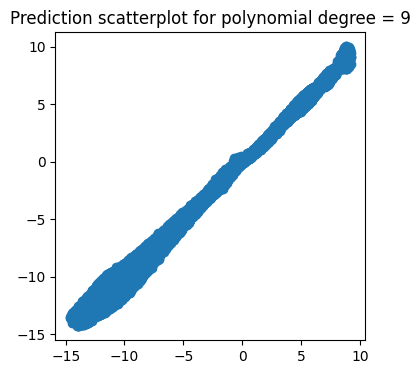

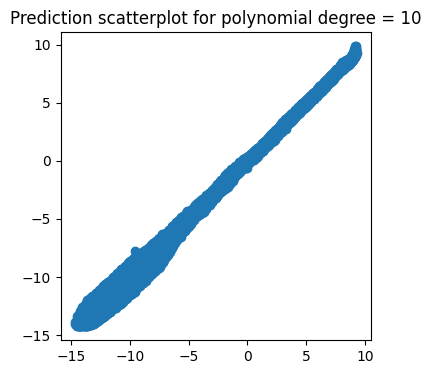

[(1, 0.8904593161756502, 1.7722253074903573, 4.809474056440134),
 (2, 0.9737675993808743, 0.83874817321295, 1.1517551818293825),
 (3, 0.9889393250199096, 0.495498157545461, 0.48562805622760535),
 (4, 0.9917927555655777, 0.41823378923114524, 0.3603458350279389),
 (5, 0.995467121532628, 0.3100762817184878, 0.19901976716504516),
 (6, 0.9965083311333846, 0.2613117619260162, 0.15330460100646018),
 (7, 0.996650483897358, 0.2521538097843345, 0.1470632666774031),
 (8, 0.9968247566069849, 0.2490906826765143, 0.13941167964659656),
 (9, 0.995655850608426, 0.32619785883349645, 0.19073346145600006),
 (10, 0.9968676206646768, 0.24459596663899696, 0.1375296978456241)]

In [158]:
fit_polynomials(X_water_train, y_water_train, 1, 10, 1)

The best score, MAE and MSE were obtained for polynominal degree = 8 and 10.

Next, it would be great to plot predicted data vs. data from the frame and make a df of predicted values as a result of modeling:)

<h3>3.3b. Izopropanol polynominal regressor</h3>

<h4>3.3b (IZOPROPANOL).1) Polynominal regression model with degree=3 </h4>

In [33]:
# Variables formatting 

poly_izo = PolynomialFeatures(degree=3)
X_izo_poly = poly_izo.fit_transform(X_izo_train)

# Model training: IZOPROPANOL

model02 = LinearRegression()
model02.fit(X_izo_poly, y_izo_train)


print('Water - regression model degree 3 INTERCEPT:', model01.intercept_)
print('Water - regression model degree 3 coeffitients:', model01.coef_)

#prediction of training sets
y_izo_poly_pred = model02.predict(X_izo_poly)

mae_reg_train= mean_absolute_error(y_izo_train, y_izo_poly_pred)
rmse_reg_train = np.sqrt(mean_squared_error(y_izo_train, y_izo_poly_pred))
r2_reg_train = r2_score(y_izo_train, y_izo_poly_pred)

print('Parameters of IZOPROPANOL regression model degree 3 - training set:')
print('MAE', mae_reg_train)
print('RMSE:', rmse_reg_train)
print('R2:', r2_reg_train)


Water - regression model degree 3 INTERCEPT: -6904.775957993821
Water - regression model degree 3 coeffitients: [ 0.00000000e+00  1.39291008e+04 -2.34097361e+01 -9.32221341e+03
  2.11286885e+01  2.73834026e+00  2.06950416e+03 -3.36017940e+00
 -1.81563679e+00 -1.04281163e-02]
Parameters of IZOPROPANOL regression model degree 3 - training set:
MAE 0.6081937587714128
RMSE: 0.8882001088212669
R2: 0.983961528735574


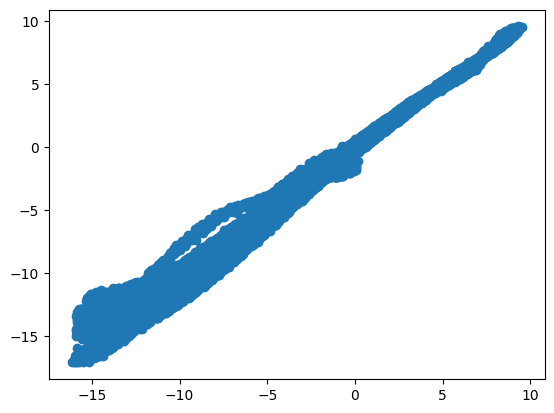

In [156]:
plt.scatter(y_izo_train,y_izo_poly_pred)

In [48]:
# prediction of TEST data and check RMSE and R2

# formatting of X:

poly_izo = PolynomialFeatures(degree=3)
X_izo_test_poly = poly_izo.fit_transform(X_izo_test)

# prediction
y_izo_test_poly_pred = model02.predict(X_izo_test_poly)


mae_reg_test= mean_absolute_error(y_izo_test, y_izo_test_poly_pred)
rmse_reg_test = np.sqrt(mean_squared_error(y_izo_test, y_izo_test_poly_pred))
r2_reg_test = r2_score(y_izo_test, y_izo_test_poly_pred)

print('Parameters of IZOPROPANOL regression model degree 3 - TEST set:')
print('MAE', mae_reg_test)
print('RMSE:', rmse_reg_test)
print('R2:', r2_reg_test)



Parameters of IZOPROPANOL regression model degree 3 - TEST set:
MAE 0.5950658124276315
RMSE: 0.8768933142686189
R2: 0.98434085395067


<h4>3.3b (IZOPROPANOL).2) Polynominal regression model with degree tuning </h4>

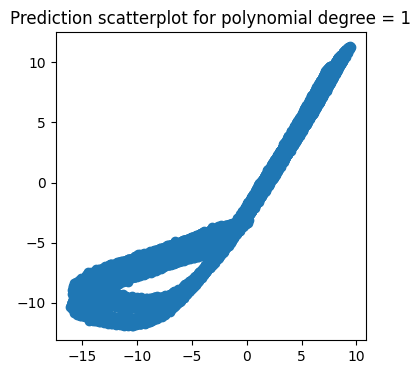

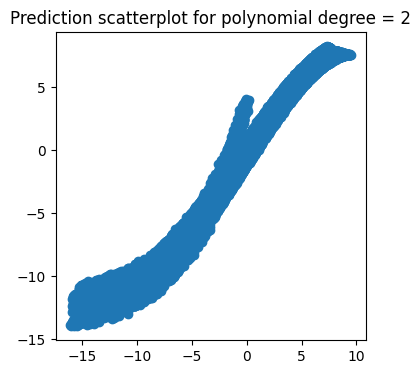

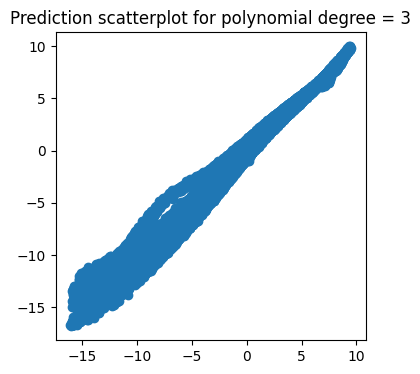

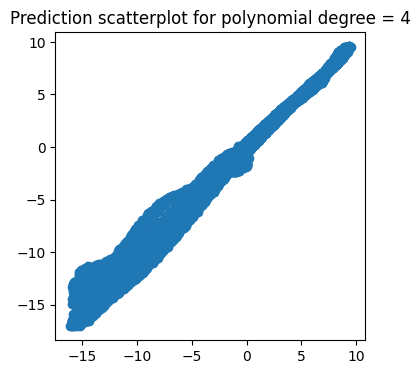

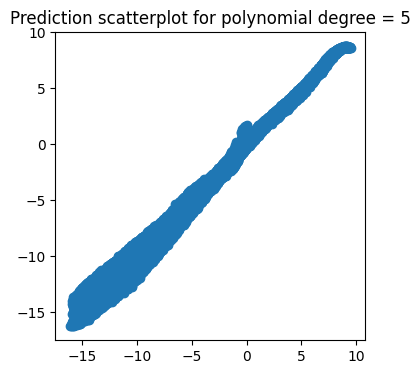

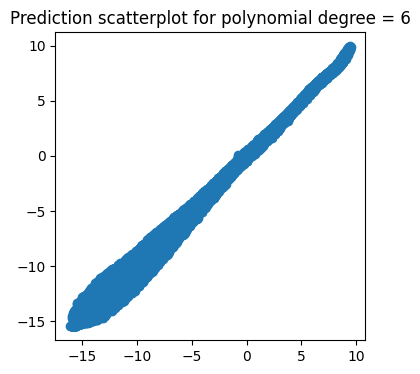

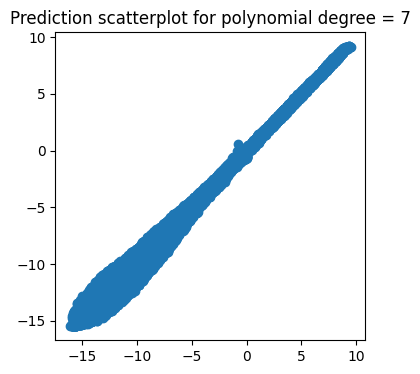

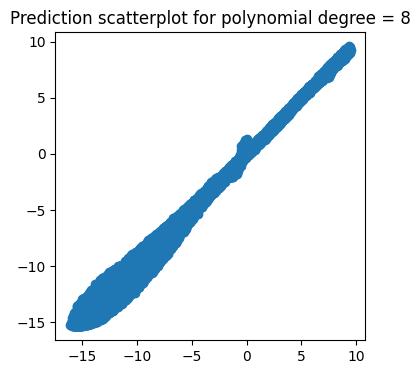

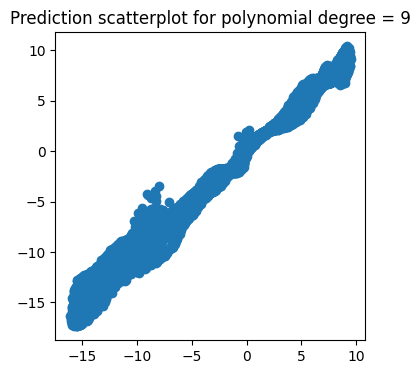

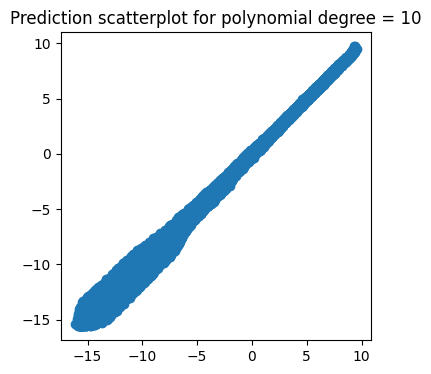

[(1, 0.8644877469401142, 2.055198713189703, 6.665569173206733),
 (2, 0.962325823859471, 1.0370672465764945, 1.8531152824777843),
 (3, 0.983961528735574, 0.6081937587714128, 0.7888994333101104),
 (4, 0.9872751208310692, 0.5305138549948749, 0.6259106494504442),
 (5, 0.9932551310828092, 0.3896724569632114, 0.3317662374920392),
 (6, 0.9951544900558849, 0.3058397440269011, 0.23834067387019017),
 (7, 0.9953275047113016, 0.2922575059271855, 0.22983043861382998),
 (8, 0.9955214951105561, 0.29301132781724193, 0.22028844963518443),
 (9, 0.9898180199261628, 0.537375115317605, 0.500830670067762),
 (10, 0.9959067369155684, 0.2685042926627144, 0.20133919713780524)]

In [160]:
fit_polynomials(X_izo_train, y_izo_train, 1, 10, 1)

<h2>3.4. MODEL: decision tree regression </h2>

<h3>3.4a. Water tree regression</h3>

<h4>3.4a.1) Decision Tree - without setting hyperparameters</h4>

In [36]:
# without hyperparameters
# model fit of water tree regression

model_dt = DecisionTreeRegressor(random_state=111)
model_dt.fit(X_water_train, y_water_train)




DecisionTreeRegressor(random_state=111)

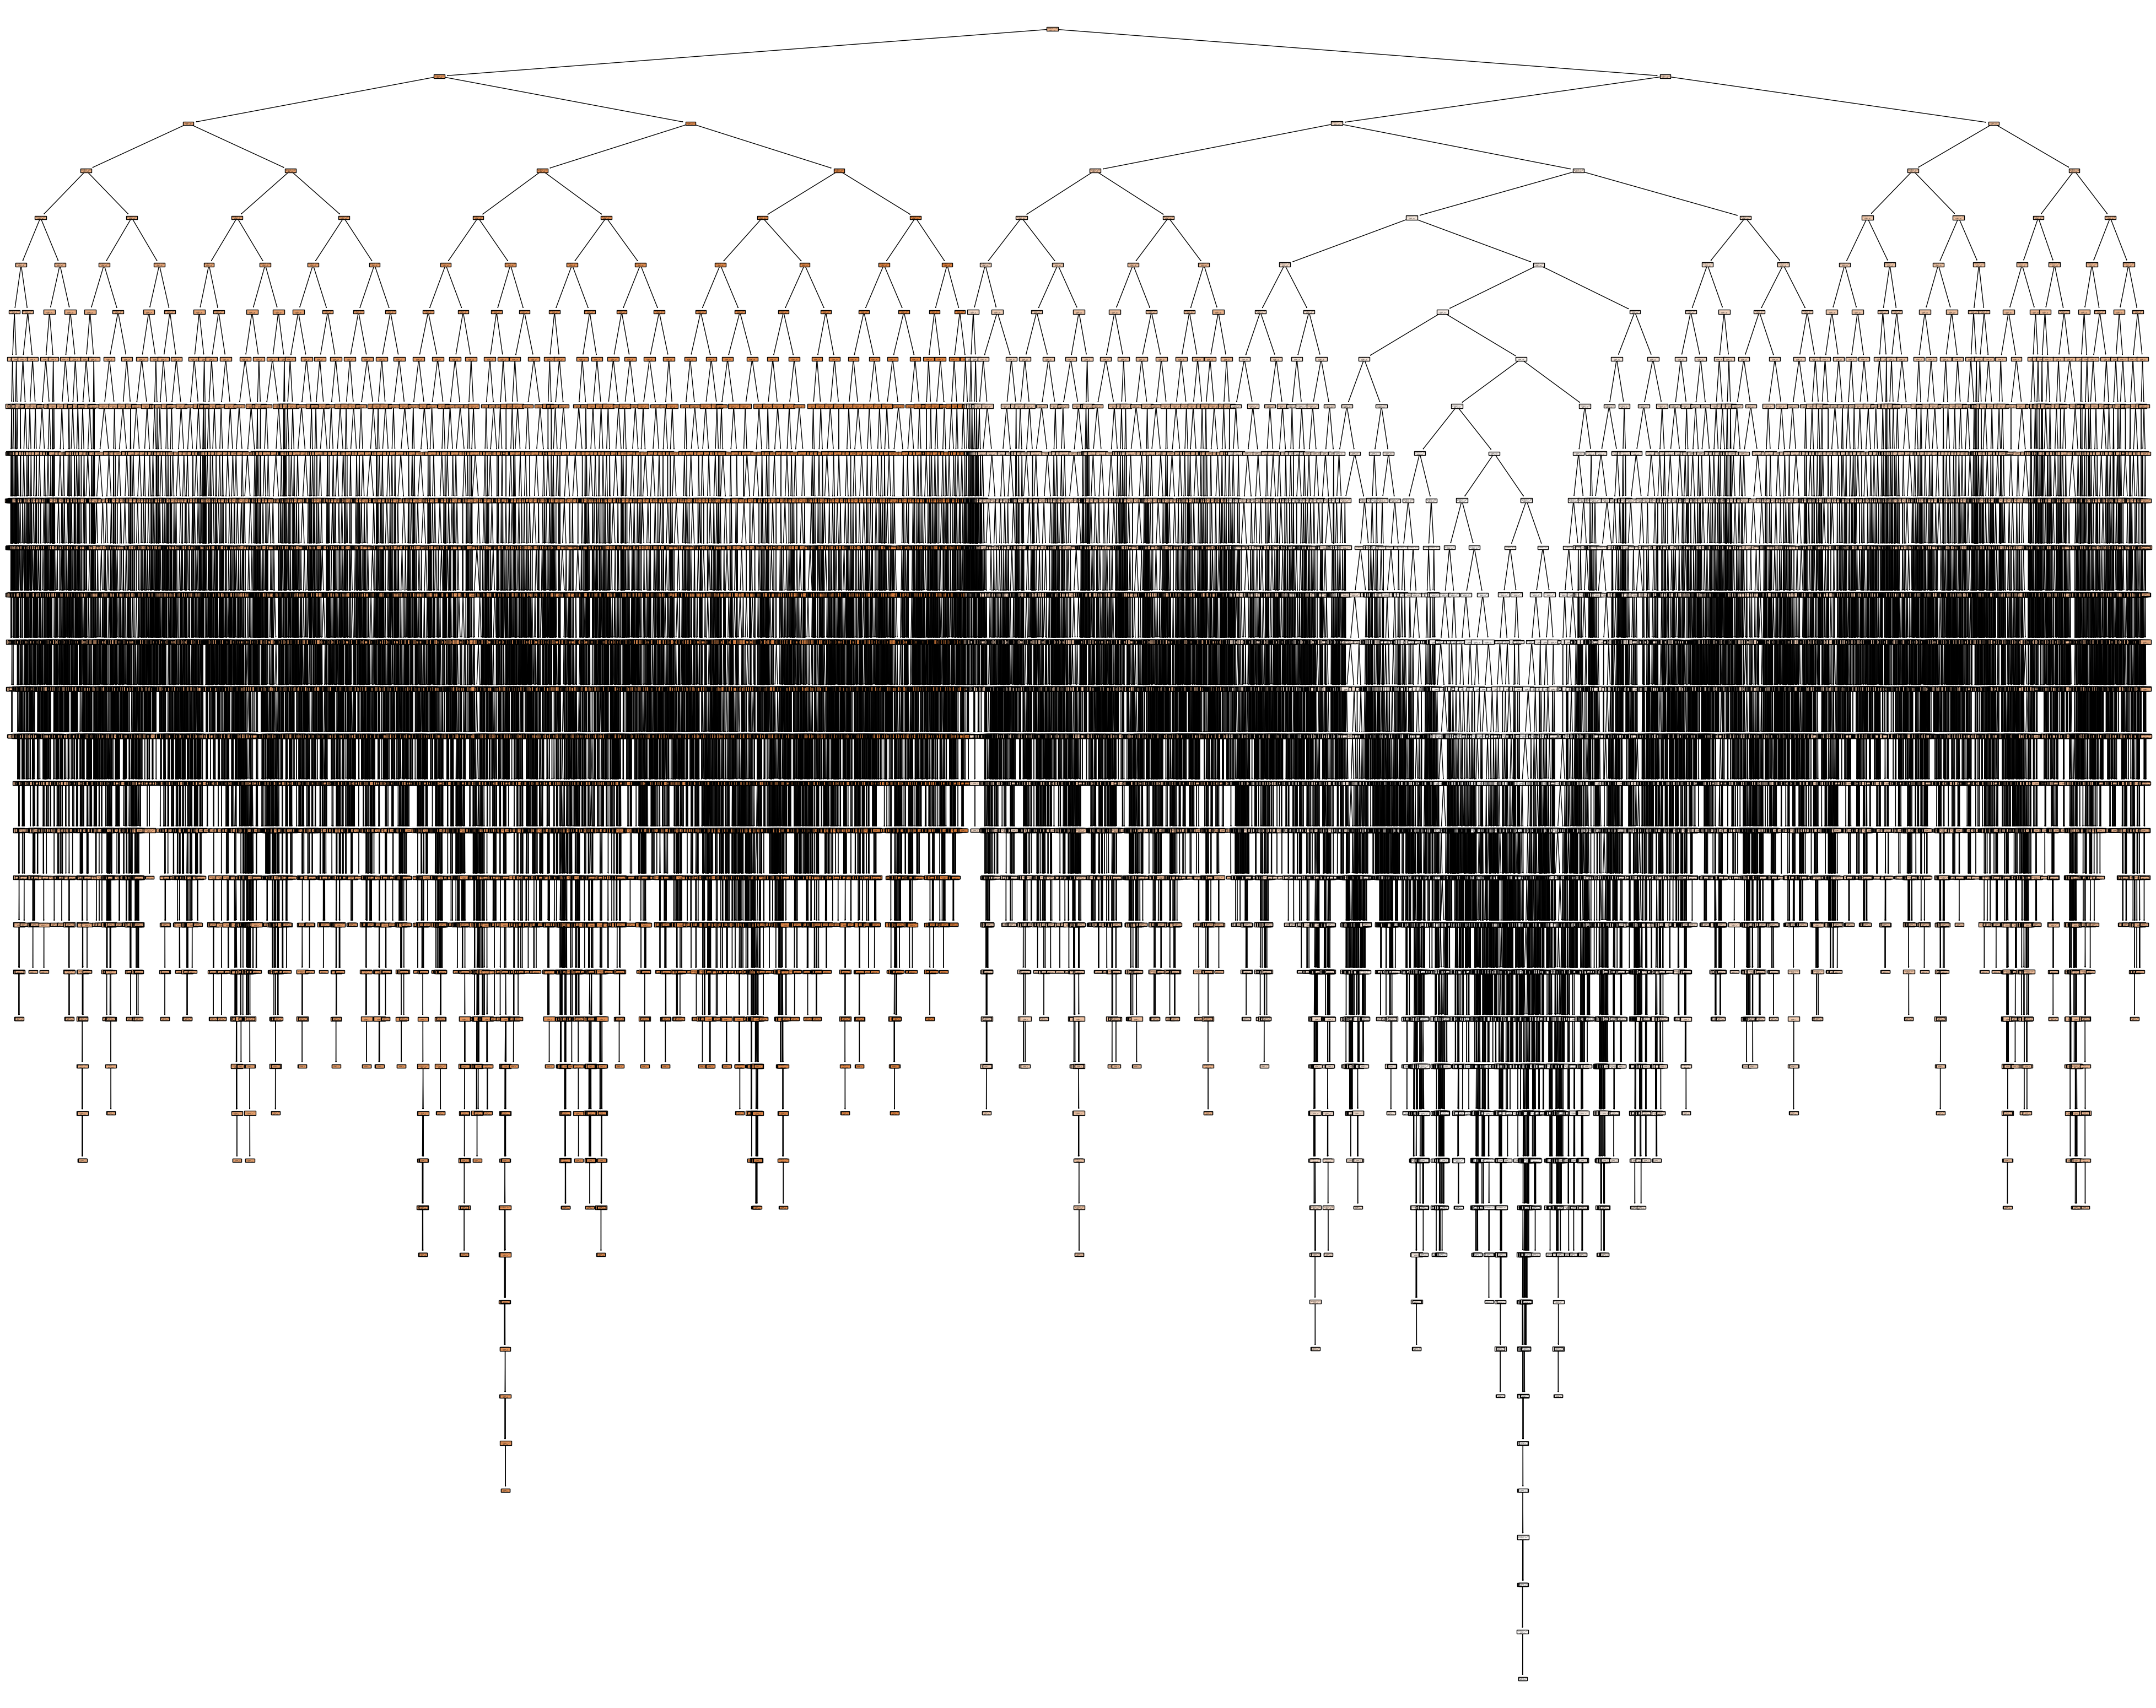

In [57]:
# plotting of the tree

fig = plt.figure(figsize=(50,40), dpi=100)
tree_fig = tree.plot_tree(model_dt,feature_names=X.columns, filled=True)


These model is too complicated and overfitted

<h4>3.4a.2) Decision Tree with set Max_depth=3</h4>

Max_depth =7 is based on the shape of Aplitude(Wavelenght) curve - there are 3 "events"

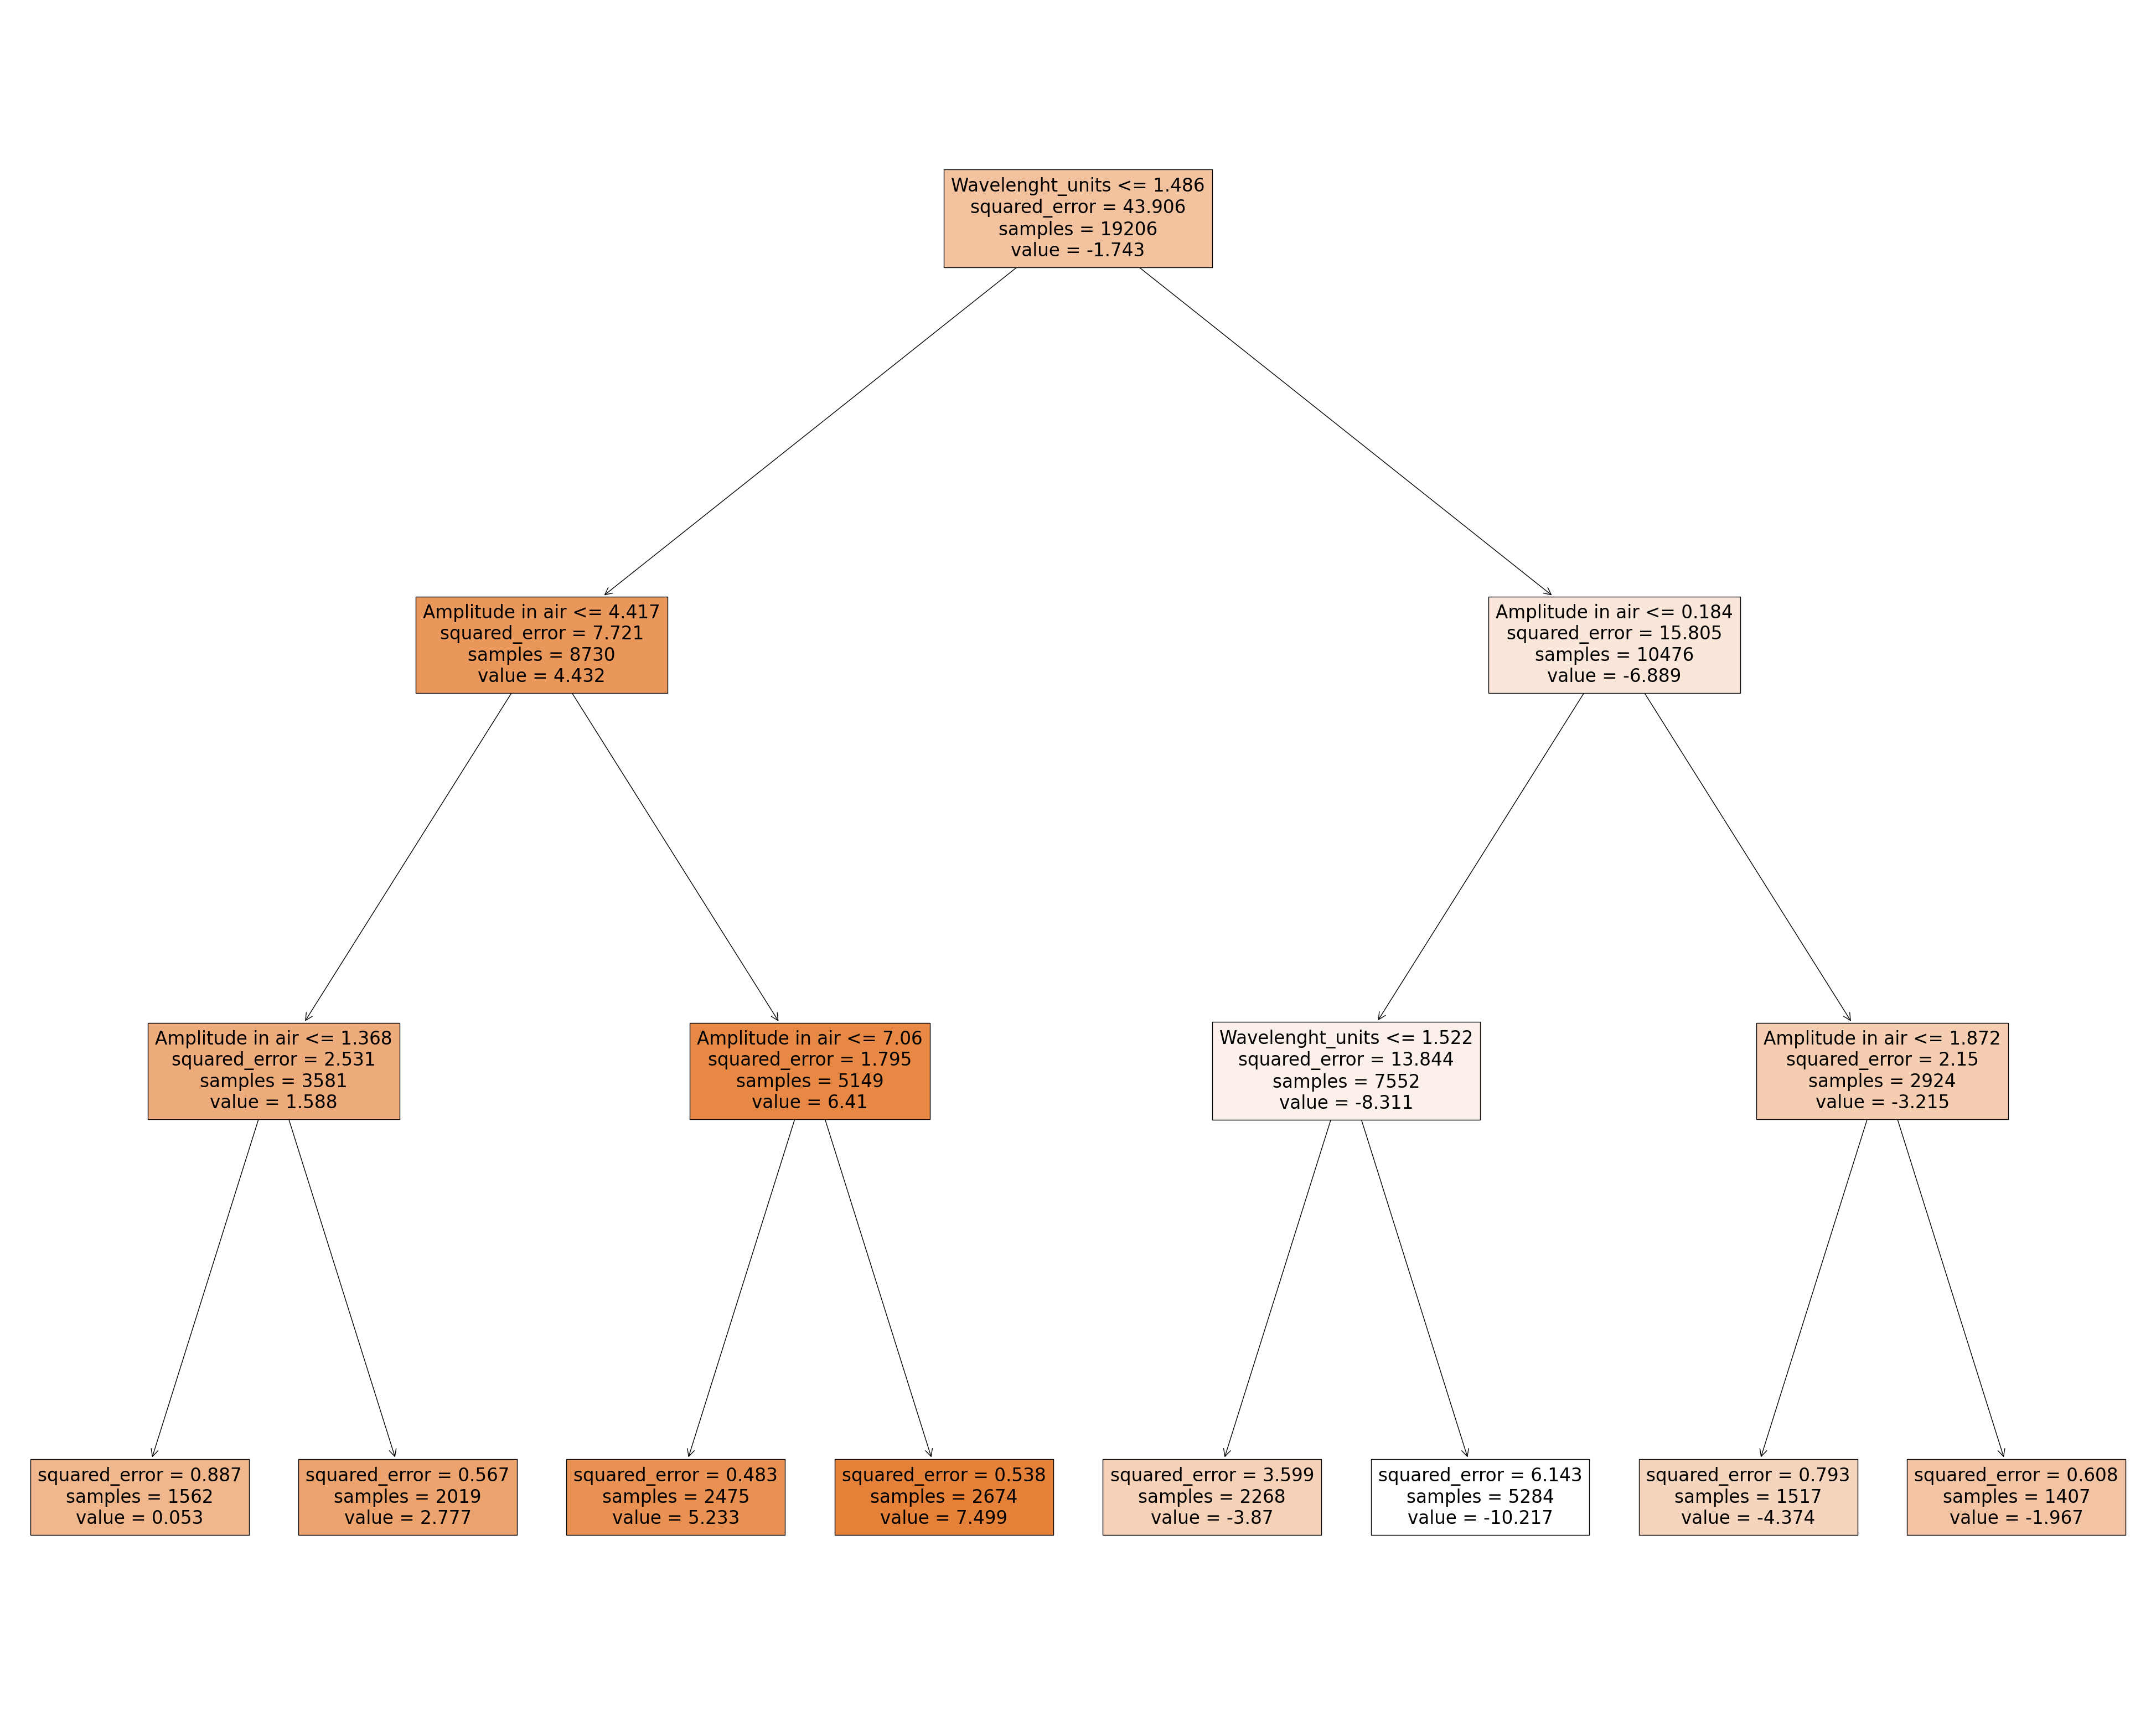

In [70]:
# Decission tree with max_depth=3;
# model fit of water decision tree regression

model_dt = DecisionTreeRegressor(random_state=111, max_depth=3)
model_dt.fit(X_water_train, y_water_train)

# plotting of the tree

fig = plt.figure(figsize=(50,40), dpi=100)
tree_fig = tree.plot_tree(model_dt,feature_names=X.columns, filled=True)

In [82]:
# Prediction for test set
y_water_pred = model_dt.predict(X_water_test)
MAE_tree_test = mean_absolute_error(y_water_test, y_water_pred)
mse_tree_test = mean_squared_error(y_water_test, y_water_pred)
rmse_tree_test = np.sqrt(mean_squared_error(y_water_test, y_water_pred))
r2_tree_test = r2_score(y_water_test, y_water_pred)

#prediction of train set
y_water_train_pred = model_dt.predict(X_water_train)
MAE_tree_train = mean_absolute_error(y_water_train, y_water_train_pred)
mse_tree_train = mean_squared_error(y_water_train, y_water_train_pred)
rmse_tree_train = np.sqrt(mean_squared_error(y_water_train, y_water_train_pred))
r2_tree_train = r2_score(y_water_train, y_water_train_pred)

print('Parameters for Decision Tree in water - model with max_depth=3')

print(f'Parameters for training data: \n MAE: {MAE_tree_train}; MSE: {mse_tree_train}; RMSE: {rmse_tree_train}; R2: {r2_tree_train}')
print(f'Parameters for test set: \n MAE: {MAE_tree_test}; MSE: {mse_tree_test}; RMSE: {rmse_tree_test}; R2: {r2_tree_test}')



Parameters for Decision Tree in water - model with max_depth=3
Parameters for training data: 
 MAE: 1.1786359303442415; MSE: 2.491276892959229; RMSE: 1.5783779309655939; R2: 0.9432586242803133
Parameters for test set: 
 MAE: 1.165746101001135; MSE: 2.4386301797468435; RMSE: 1.561611404846559; R2: 0.9433136030097026


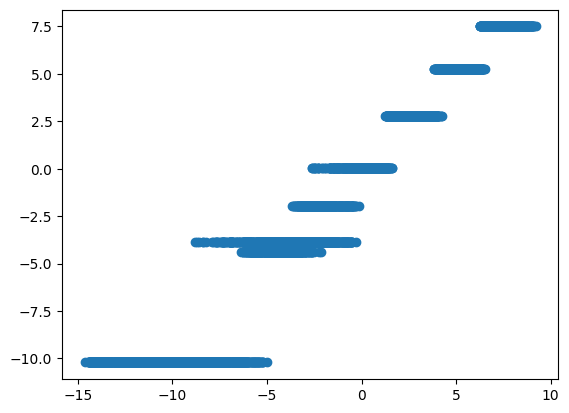

In [83]:
plt.scatter(y_water_test,y_water_pred)

<h4>3.4a.3) Decision tree - hyperparameter tuning with GridSearch</h4>

In [69]:
from sklearn.model_selection import GridSearchCV


gs = GridSearchCV(DecisionTreeRegressor(),
                  param_grid = {'max_depth': range(1, 10)
                                },
                  cv=20,
                  scoring='neg_mean_absolute_error')
gs.fit(X_water_train,y_water_train)

print(gs.best_params_)
print(gs.best_score_)


{'max_depth': 9}
-0.23143265058598642


In [84]:
# fitting of the modelwith optimized parameters
model_dt_opt = DecisionTreeRegressor(max_depth=9, random_state=111)
model_dt_opt.fit(X_water_train,y_water_train)

# prediction of the model with optimized parameters
pred_train_dt_opt = model_dt_opt.predict(X_water_train)
pred_test_dt_opt = model_dt_opt.predict(X_water_test)

# metrics of the decision tree model with optimized parameters

MAE_tree_test = mean_absolute_error(y_water_test, pred_test_dt_opt)
mse_tree_test = mean_squared_error(y_water_test, pred_test_dt_opt)
rmse_tree_test = np.sqrt(mean_squared_error(y_water_test, pred_test_dt_opt))
r2_tree_test = r2_score(y_water_test, pred_test_dt_opt)


MAE_tree_train = mean_absolute_error(y_water_train, pred_train_dt_opt)
mse_tree_train = mean_squared_error(y_water_train, pred_train_dt_opt)
rmse_tree_train = np.sqrt(mean_squared_error(y_water_train, pred_train_dt_opt))
r2_tree_train = r2_score(y_water_train, pred_train_dt_opt)

print('Parameters for Decision Tree in water - model with GridSearch optimized parameters max_depth=9')
print(f'Parameters for training data: \n MAE: {MAE_tree_train}; MSE: {mse_tree_train}; RMSE: {rmse_tree_train}; R2: {r2_tree_train}')
print(f'Parameters for test set: \n MAE: {MAE_tree_test}; MSE: {mse_tree_test}; RMSE: {rmse_tree_test}; R2: {r2_tree_test}')


Parameters for Decision Tree in water - model with GridSearch optimized parameters max_depth=9
Parameters for training data: 
 MAE: 0.21100897819408815; MSE: 0.127787916798721; RMSE: 0.3574743582394701; R2: 0.9970894996778542
Parameters for test set: 
 MAE: 0.2264217059508598; MSE: 0.14239112172916055; RMSE: 0.37734748141356467; R2: 0.9966900927736936


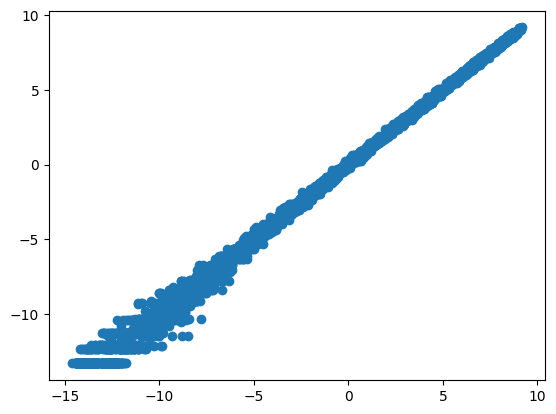

In [85]:
plt.scatter(y_water_test,pred_test_dt_opt)

<h3>3.4b. Izopropanol tree regression</h3>

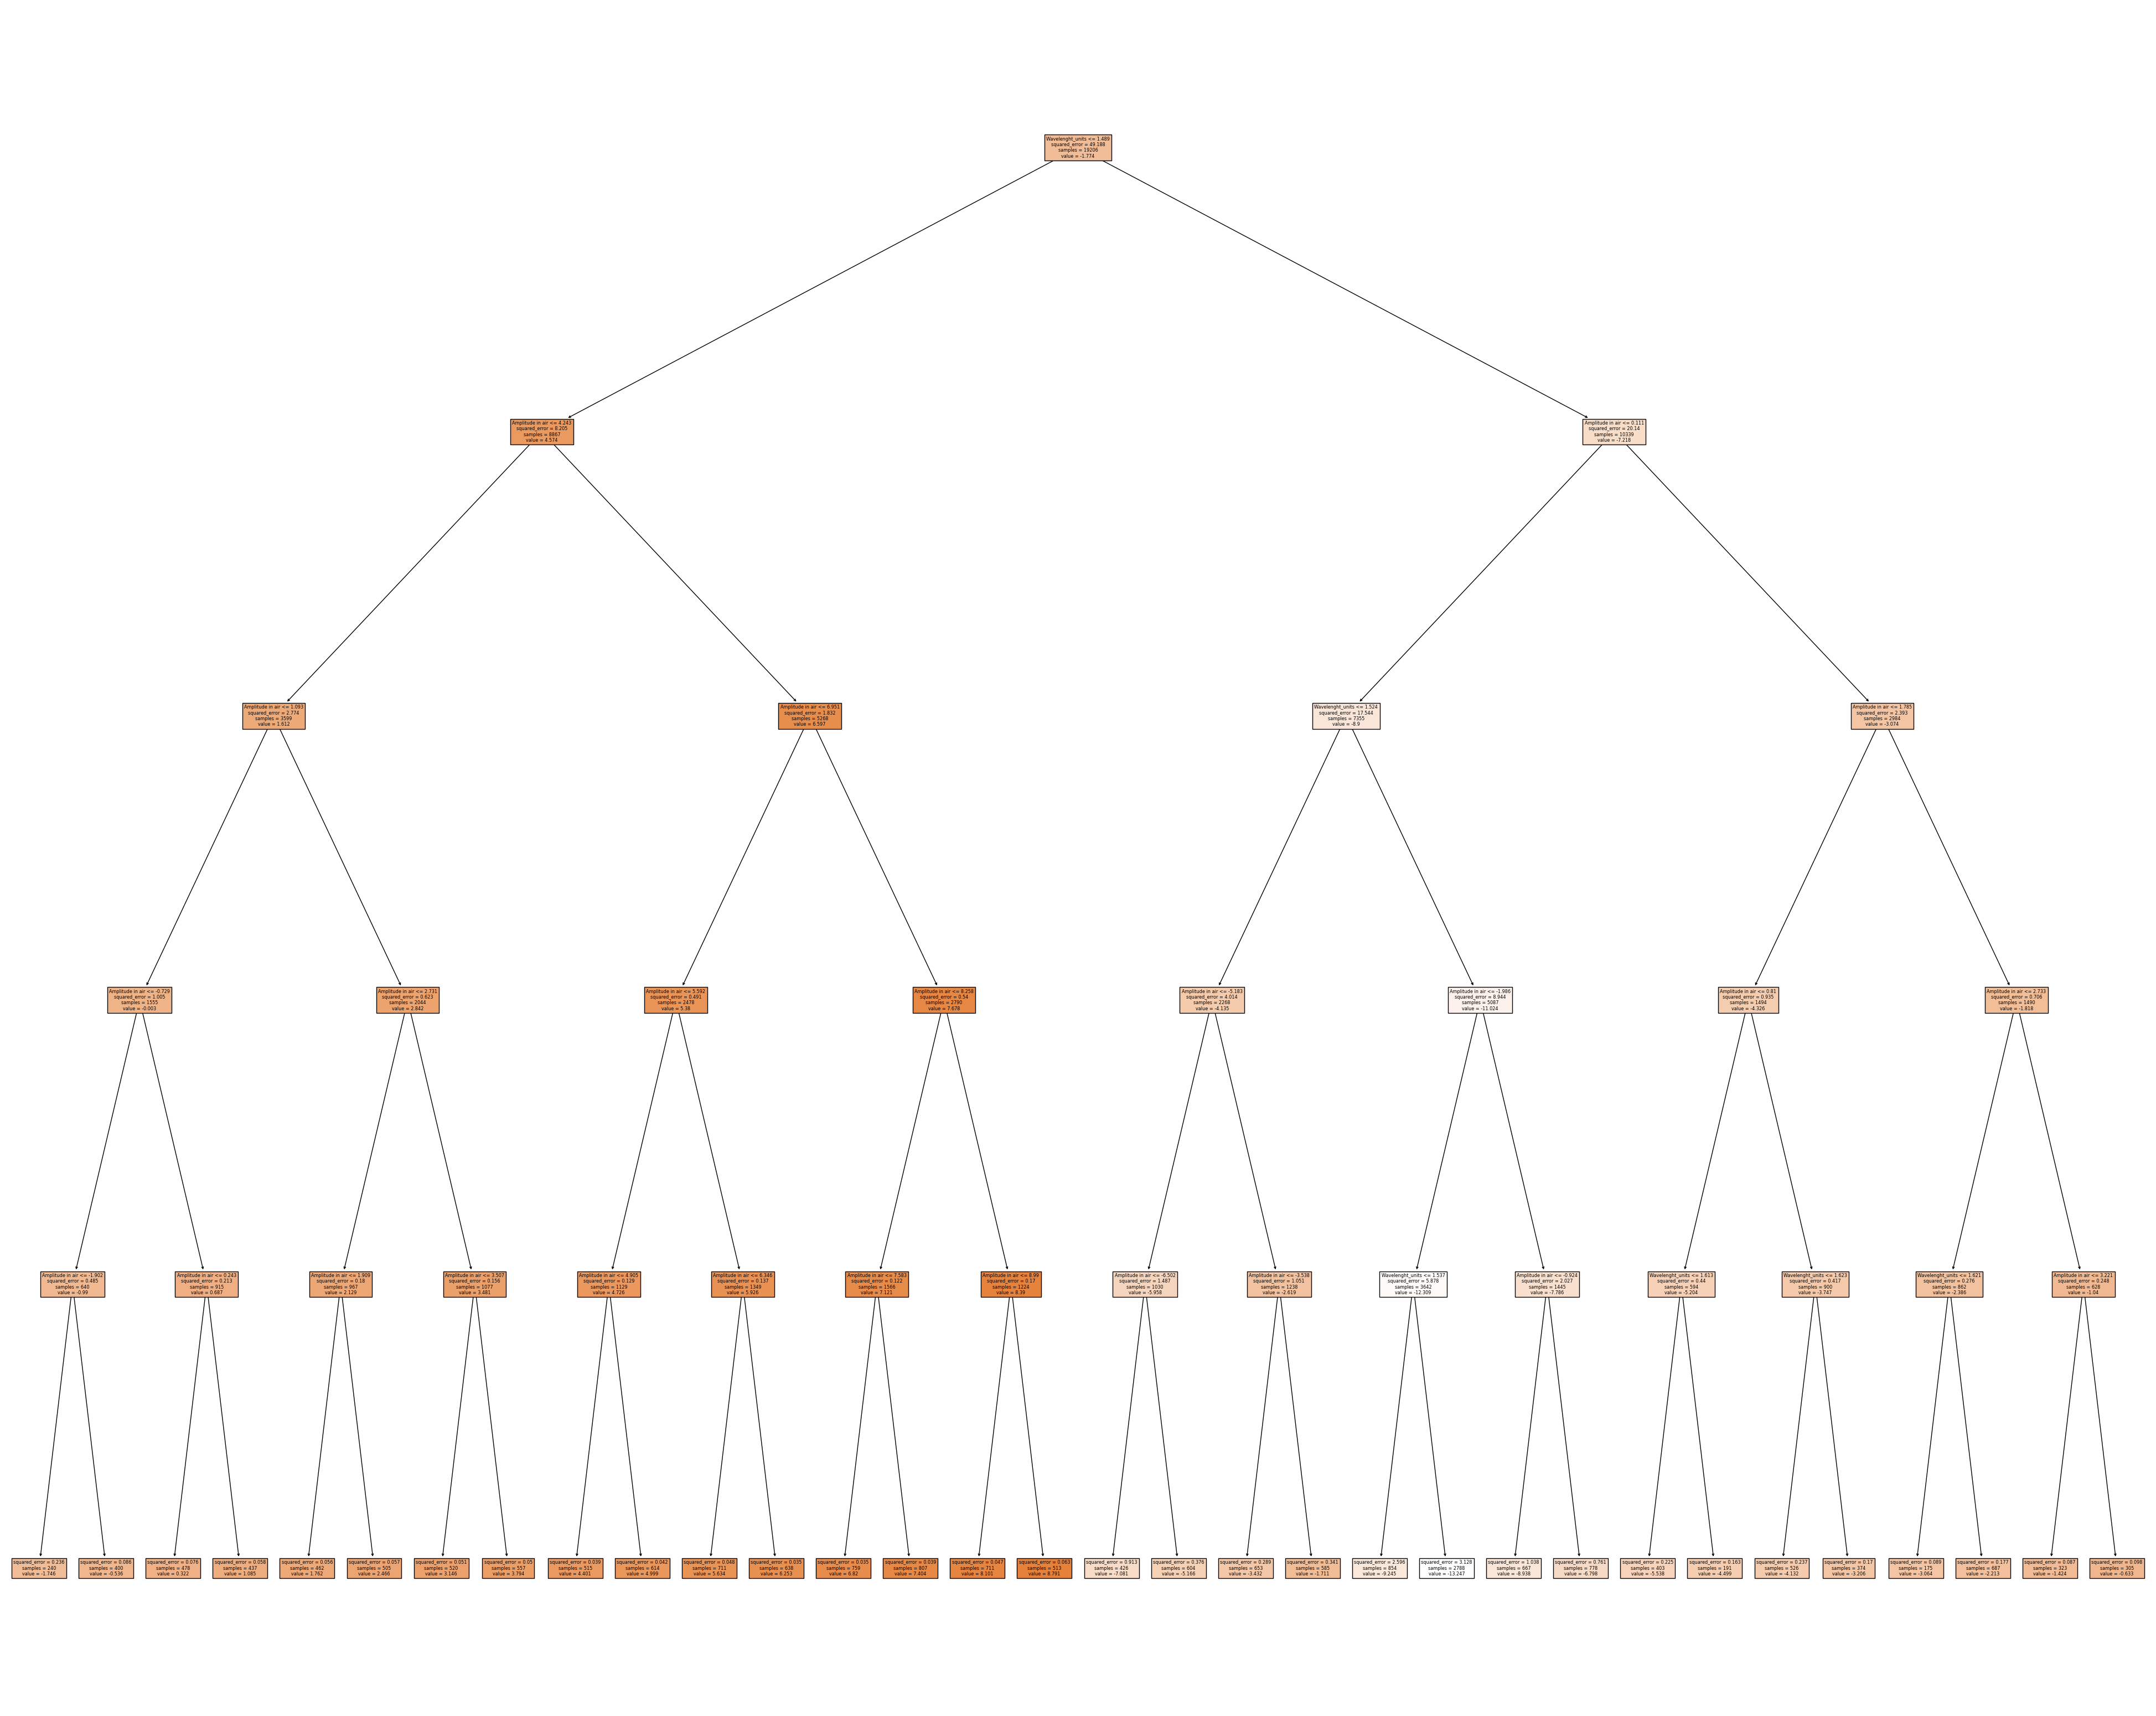

In [40]:
# model fit of izopropanol tree regression - MaxDepth = 5

model_izo_dt = DecisionTreeRegressor(random_state=111, max_depth=5)
model_izo_dt.fit(X_izo_train, y_izo_train)

# plotting of the tree

fig = plt.figure(figsize=(50,40), dpi=100)
tree_fig = tree.plot_tree(model_izo_dt,feature_names=X.columns, filled=True)

In [41]:
# Prediction for test set
y_izo_pred = model_izo_dt.predict(X_izo_test)
MAE_tree_test = mean_absolute_error(y_izo_test, y_izo_pred)
rmse_tree_test = np.sqrt(mean_squared_error(y_izo_test, y_izo_pred))
r2_tree_test = r2_score(y_izo_test, y_izo_pred)

#prediction of train set
y_izo_train_pred = model_izo_dt.predict(X_izo_train)
MAE_tree_train = mean_absolute_error(y_izo_train, y_izo_train_pred)
rmse_tree_train = np.sqrt(mean_squared_error(y_izo_train, y_izo_train_pred))
r2_tree_train = r2_score(y_izo_train, y_izo_train_pred)

print('Parameters for Decision Tree in IZOPROPANOL - model with max_depth=5')

print('MAE of decission tree regressor test set in izopropanol:', MAE_tree_test)
print('MAE of decission tree regressor train set in izopropanol:', MAE_tree_train)
print('RMSE of decission tree regressor for test set in izopropanol:', rmse_tree_test)
print('RMSE of decission tree regressor for train set in izopropanol:', rmse_tree_train)

print('model score for train set:', model_dt.score(X_izo_train,y_izo_train))
print('model score for test set:', model_dt.score(X_izo_test,y_izo_test))
print('R2 of decission tree regressor for test set in izopropanol:', r2_tree_test)
print('R2 of decission tree regressor for train set in izopropanol:', r2_tree_train)


Parameters for Decision Tree in IZOPROPANOL - model with max_depth=5
MAE of decission tree regressor test set in izopropanol: 0.5350185742291392
MAE of decission tree regressor train set in izopropanol: 0.5385835507357924
RMSE of decission tree regressor for test set in izopropanol: 0.8561714287834404
RMSE of decission tree regressor for train set in izopropanol: 0.8604312912803649
model score for train set: 0.988538198544836
model score for test set: 0.9881825088838514
R2 of decission tree regressor for test set in izopropanol: 0.9850721927483843
R2 of decission tree regressor for train set in izopropanol: 0.98494871018537


In [42]:
# decision three model for max_depth=7 -> it is connected with shape of plotted Wavelenght and Amplitude curve shape -> there are 7 "events"
model_izo_dt = DecisionTreeRegressor(random_state=111, max_depth=7)
model_izo_dt.fit(X_izo_train, y_izo_train)

# Prediction for test set
y_izo_pred = model_izo_dt.predict(X_izo_test)
MAE_tree_test = mean_absolute_error(y_izo_test, y_izo_pred)
rmse_tree_test = np.sqrt(mean_squared_error(y_izo_test, y_izo_pred))
r2_tree_test = r2_score(y_izo_test, y_izo_pred)

#prediction of train set
y_izo_train_pred = model_izo_dt.predict(X_izo_train)
MAE_tree_train = mean_absolute_error(y_izo_train, y_izo_train_pred)
rmse_tree_train = np.sqrt(mean_squared_error(y_izo_train, y_izo_train_pred))
r2_tree_train = r2_score(y_izo_train, y_izo_train_pred)

print('Parameters for Decision Tree in IZOPROPANOL - model with max_depth=7')

print('MAE of decission tree regressor test set in izopropanol:', MAE_tree_test)
print('MAE of decission tree regressor train set in izopropanol:', MAE_tree_train)
print('RMSE of decission tree regressor for test set in izopropanol:', rmse_tree_test)
print('RMSE of decission tree regressor for train set in izopropanol:', rmse_tree_train)

print('model score for train set:', model_dt.score(X_izo_train,y_izo_train))
print('model score for test set:', model_dt.score(X_izo_test,y_izo_test))
print('R2 of decission tree regressor for test set in izopropanol:', r2_tree_test)
print('R2 of decission tree regressor for train set in izopropanol:', r2_tree_train)


Parameters for Decision Tree in IZOPROPANOL - model with max_depth=7
MAE of decission tree regressor test set in izopropanol: 0.3248498538332128
MAE of decission tree regressor train set in izopropanol: 0.3161031711487075
RMSE of decission tree regressor for test set in izopropanol: 0.5617670234733141
RMSE of decission tree regressor for train set in izopropanol: 0.5471843089256389
model score for train set: 0.988538198544836
model score for test set: 0.9881825088838514
R2 of decission tree regressor for test set in izopropanol: 0.9935733146005704
R2 of decission tree regressor for train set in izopropanol: 0.9939129257910859


Function for creating a df with parameters should be generated OR ML flow could be used

The best model is polynominal regression with degree=4 -> highest R2 and lowest MSE were obtained.

<h2>4.5. MODEL: autoML</h2>

AutoML model is not working, some libraries needs to be installed

In [ ]:
!pip install flaml
!pip install fairlearn
!pip install interpret-community
!pip install raiwidgets
!pip install lightgbm

In [ ]:
conda install py-xgboost

In [ ]:
# Train a model with FLAML
from flaml import AutoML



# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 1,  # in seconds
    "metric": 'mae',
    "task": 'regression'
}
# Train with labeled input data

#water
automl.fit(X_train=X_water_train, y_train=y_water_train,
           **automl_settings)

# Predict
print(automl.predict(X_water_train))
# Print the best model
print(automl.model.estimator)

wyznacz minimum lokalne funkcji